In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax
import jax.numpy as jnp

In [2]:
n = 50
p = 0.2
t = jax.scipy.special.logit(p)
At = lambda t: -n * jnp.log(1 - jax.scipy.special.expit(t))
g = lambda t, x: t * x - At(t)
dg = jax.grad(g)
dg_vmap = jax.vmap(dg, in_axes=(None, 0))

holderp = 1.2
holderq = 6.0
# holderq = 1.0 / (1 - 1.0 / holderp)

### The constant term

Compute the constant term using both a numerical sum and using the 6th moment formula from wikipedia

In [3]:
# numerical integral to compute E[ |grad g|^q]^(1/q)
# need to compute for the worst t in the "tile".
def C_numerical(t, p):
    xs = jnp.arange(n + 1).astype(jnp.float64)
    eggq = jnp.abs(dg_vmap(t, xs)) ** holderq
    return sum(eggq * scipy.stats.binom.pmf(xs, n, p)) ** (1 / holderq)

# Formula for C with q = 6 from wikipedia
def C_wiki(p):
    assert(holderq == 6)
    return (n * p * (1 - p) * (1 - 30 * p * (1 - p) * (1 - 4 * p * (1 - p)) + 5 * n * p * (1 - p) * (5 - 26 * p * (1 - p)) + 15 * n ** 2 * p ** 2 * (1 - p) ** 2)) ** (1 / 6)

# p = 0.2 corresponds to t=-1.386
# choose theta = -1.1 as the edge of our tile.
# so our tile is going to extend unidirectionally from -1.386 (the grid pt) to -1.1
# since the constant is monotonic in the relevant region, we can just compute
# at the edge of the tile to get a maximum value.
tmax = -1.1
pmax = jax.scipy.special.expit(tmax)
C = C_wiki(pmax)
C_numerical(tmax, pmax), C_wiki(pmax)

(DeviceArray(4.81013915, dtype=float64),
 DeviceArray(4.81013915, dtype=float64, weak_type=True))

### Is the constant term monotonic? 

It's unimodal. Monotonic in [0, 0.5] and separately in [0.5, 1].

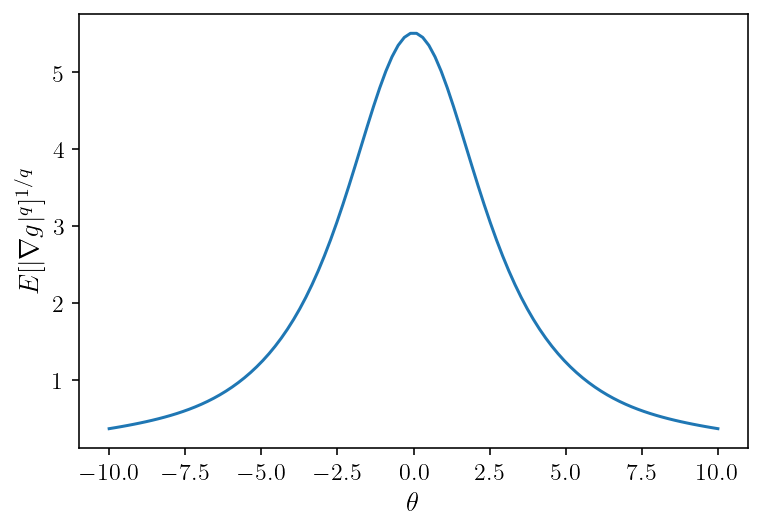

In [4]:
ts = np.linspace(-10, 10, 100)
cs = [C_numerical(t, jax.scipy.special.expit(t)) for t in ts]
plt.plot(ts, cs)
plt.ylabel(r'$E[|\nabla g|^q]^{1/q}$')
plt.xlabel(r"$\theta$")
plt.show()

## Computing bounds for a simple binomial test.

For holder bounds, it's only necessary to choose a Type I Error value. 

But, to compute a classical gradient, it helps to have a real test that we're considering.

Here, we choose a test where we reject the null if x >= 19 and n=50. 

We're considering a tile where true p at the center of the tile is 0.2 and true theta is -1.38

The true Type I Error should be ~0.093%:

In [5]:
thresh = 20
# the minus 1 is to account for cdf = p(x <= x) and we want p(x >= x)
1 - scipy.stats.binom.cdf(thresh - 1, n, p)

0.0009324364894210957

### Simulation

In [6]:
delta = 0.01
nsims=int(1e4)
np.random.seed(0)
samples = scipy.stats.binom.rvs(n, p, size=nsims)
reject = samples >= thresh
typeI_sum = np.sum(reject)
typeI_est = typeI_sum / nsims
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
typeI_est, typeI_CI

(0.0011, 0.0010478639746356723)

### Holder-ODE solution

In [7]:
# use the upper bound on t1e
f0 = typeI_est + typeI_CI

# integration distance to reach the edge of the tile.
dt = tmax - t
t_path = np.linspace(t, t + dt, 100)

R = f0 ** (1/holderq) - t * C / holderq
analytical = (t_path * C / holderq + R) ** holderq

### Classical bound

In [8]:
grad_est = np.sum(reject * (samples - n * p)) / nsims

covar = n * p * (1 - p)
grad_bound = np.sqrt(covar / nsims * (1 / delta - 1))

# use pmax for a worst case hessian bound.
hess_bound = n * pmax * (1 - pmax)

Comparing gradient estimates: In this regime, classical gradient bound is ~10x larger than the Holder gradient bound. So, Holder gradient bound could be substituted in here for an improvement.

In [9]:
grad_est + grad_bound, C * f0 ** (1 / holderp)

(0.29372494558940576, DeviceArray(0.02876272, dtype=float64))

In [10]:
classical = f0 + (grad_est + grad_bound) * (t_path - t) + 0.5 * hess_bound * (t_path - t) ** 2

## Comparing bounds

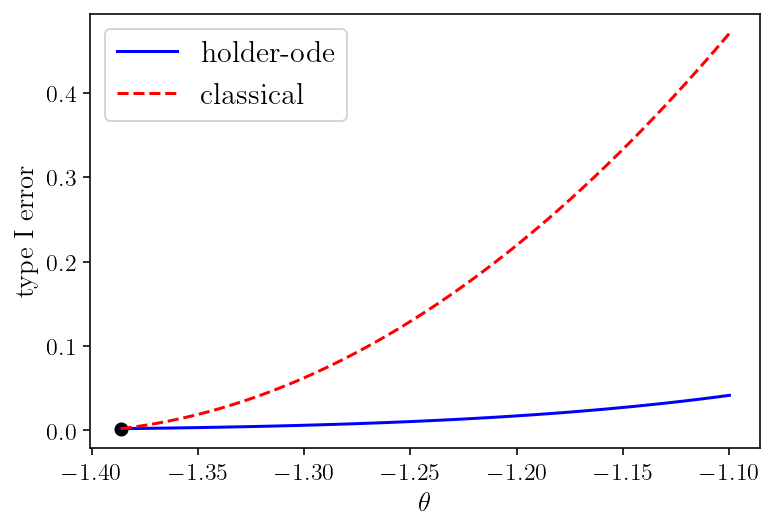

In [11]:
plt.plot([t], [f0], 'ko')
plt.plot(t_path, analytical, 'b-', label='holder-ode')
plt.plot(t_path, classical, 'r--', label='classical')
plt.xlabel(r'$\theta$')
plt.ylabel('type I error')
plt.legend()
plt.show()

Computing the bound at the upper edge of the tile.

In [12]:
analytical[-1], classical[-1]

(DeviceArray(0.04163348, dtype=float64),
 DeviceArray(0.47018144, dtype=float64))

Computing the point where the bound crosses 0.025 and then compute the maximum cell size that would avoid the bound crossing 0.025.

In [13]:
holder_idx = np.argmin(analytical < 0.025)
classical_idx = np.argmin(classical < 0.025)
holder_cell_size = (t_path[holder_idx] - t)
classical_cell_size = (t_path[classical_idx] - t)

t_path[holder_idx], t_path[classical_idx], holder_cell_size, classical_cell_size

(-1.157837244670685,
 -1.3400245653833427,
 DeviceArray(0.22845712, dtype=float64),
 DeviceArray(0.0462698, dtype=float64))

The ratio of cell sizes. This is a guess at the ratio of the number of cells that would be required if we switched to using holder in regions of comparably low T1E. This corresponds to a reduction of 500x in the number of tiles required for a 4D problem with low T1E.

In [14]:
holder_cell_size / classical_cell_size

DeviceArray(4.9375, dtype=float64)

## Checking the ODE integrator

Against the analytical solution

In [15]:
def derivs(_, y):
    cur_f = y[0]
    return C * cur_f ** (1 / holderp)
holderode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)

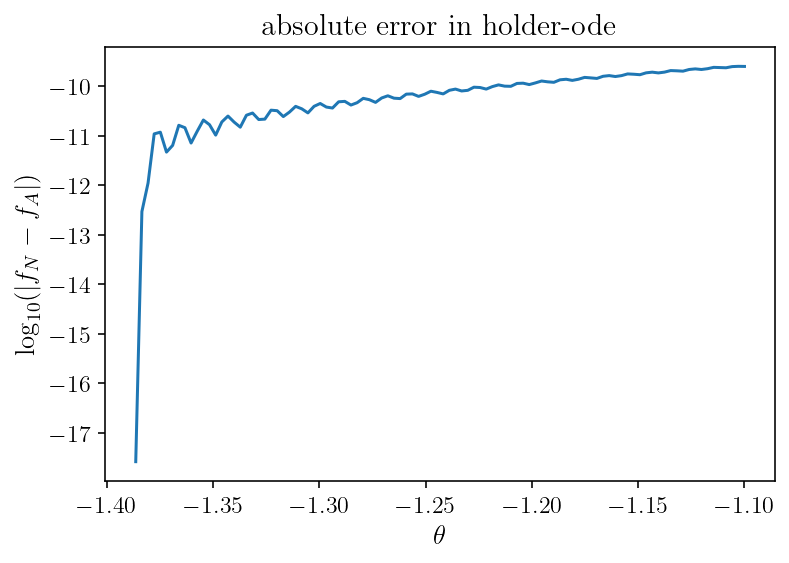

In [16]:
error = analytical - holderode['y'][0,:]
plt.plot(t_path, np.log10(np.abs(error)))
plt.title('absolute error in holder-ode')
plt.xlabel(r'$\theta$')
plt.ylabel('$\log_{10}(|f_N - f_A|)$')
plt.show()

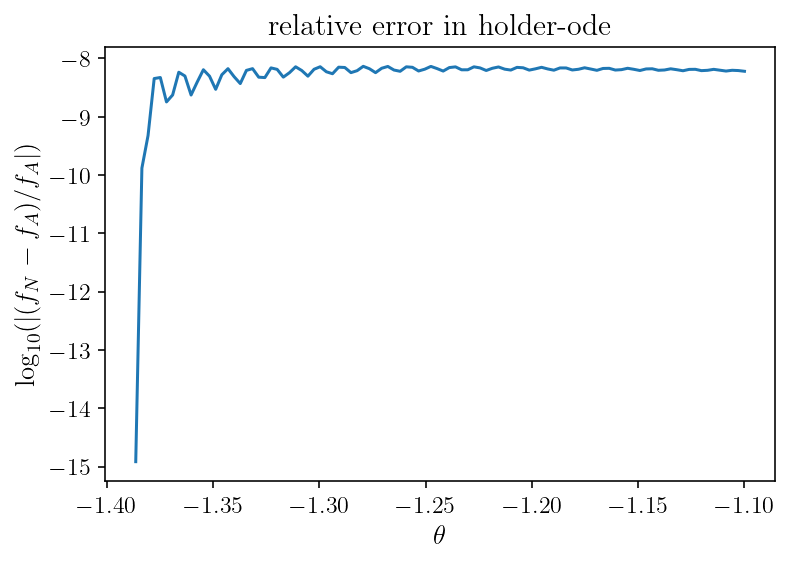

In [17]:
plt.plot(t_path, np.log10(np.abs(error / analytical)))
plt.title('relative error in holder-ode')
plt.xlabel(r'$\theta$')
plt.ylabel('$\log_{10}(|(f_N - f_A) / f_A|)$')
plt.show()